# Death-Rates in the US
> Data is taken from https://www.kaggle.com/cdc/mortality

> Further information can be found at http://www.cdc.gov/nchs/data/dvs/Record_Layout_2014.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
import seaborn as sns
import pymc3 as pm
%matplotlib inline

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
Data=pd.read_csv("../DeathRecords.csv")
Data.head()

,Id,ResidentStatus,Education1989Revision,Education2003Revision,EducationReportingFlag,MonthOfDeath,Sex,AgeType,Age,AgeSubstitutionFlag,...,CauseRecode39,NumberOfEntityAxisConditions,NumberOfRecordAxisConditions,Race,BridgedRaceFlag,RaceImputationFlag,RaceRecode3,RaceRecode5,HispanicOrigin,HispanicOriginRaceRecode
0,1,1,0,2,1,1,M,1,87,0,...,24,1,1,1,0,0,1,1,100,6
1,2,1,0,2,1,1,M,1,58,0,...,21,3,3,1,0,0,1,1,100,6
2,3,1,0,7,1,1,F,1,75,0,...,28,2,2,1,0,0,1,1,100,6
3,4,1,0,6,1,1,M,1,74,0,...,22,3,3,1,0,0,1,1,100,6
4,5,1,0,3,1,1,M,1,64,0,...,21,1,1,1,0,0,1,1,100,6


In [3]:
Causes=pd.read_csv("39CauseRecode.csv")

In [4]:
print Causes['Cause']
print len(Causes)
print type(Causes)

0                                          Tuberculosis
1                                              Syphilis
2            Human immunodeficiency virus (HIV) disease
3                                   Malignant neoplasms
4                         Malignant neoplasm of stomach
5         Malignant neoplasms of colon, rectum and anus
6                        Malignant neoplasm of pancreas
7     Malignant neoplasms of trachea, bronchus and lung
8                          Malignant neoplasm of breast
9     Malignant neoplasms of cervix uteri, corpus ut...
10                       Malignant neoplasm of prostate
11                 Malignant neoplasms of urinary tract
12                               Non-Hodgkin's lymphoma
13                                             Leukemia
14                            Other malignant neoplasms
15                                    Diabetes mellitus
16                                  Alzheimer's disease
17                        Major cardiovascular d

In [6]:
Older_than_one=Data['Age'][Data['AgeType']==1]

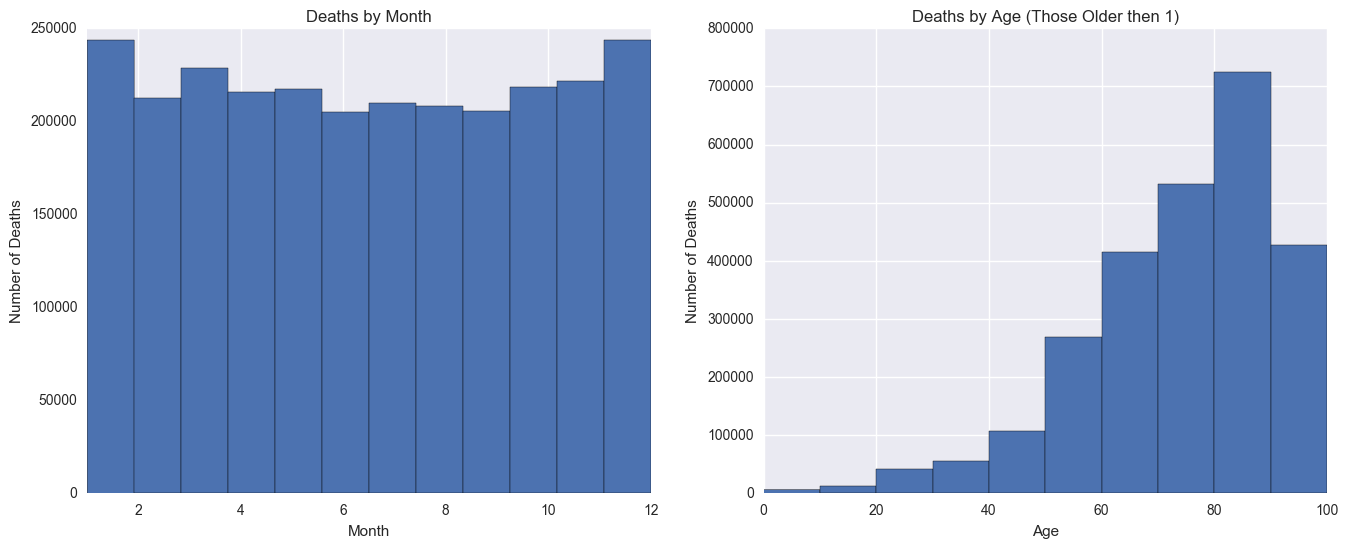

In [7]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.hist(Data['MonthOfDeath'],bins=12)
ax1.set_title('Deaths by Month')
ax1.set_xlim(1,12)
ax1.set_xticks(range(1,13),list('JFMAMJJASOND'))
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Deaths')
ax2.hist(Older_than_one,bins=10,range=(0,100))
ax2.set_title('Deaths by Age (Those Older then 1)')
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of Deaths')
plt.show()

In [8]:
male_deaths=Data['Age'][Data['Sex']=='M'][Data['AgeType']==1]
female_deaths=Data['Age'][Data['Sex']=='F'][Data['AgeType']==1]

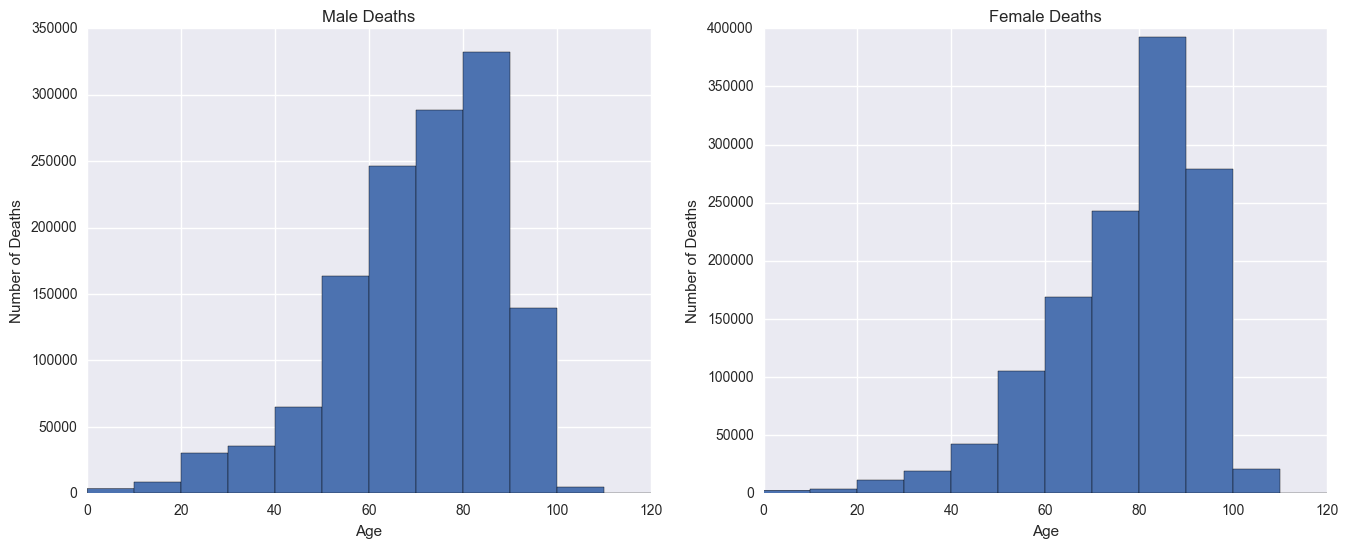

In [9]:
fig=plt.figure(figsize=(16,6))
plot1=fig.add_subplot(1,2,1)
plot2=fig.add_subplot(1,2,2)
plot1.hist(male_deaths,bins=12,range=(0,120))
plot1.set_title('Male Deaths')
plot1.set_xlabel('Age')
plot1.set_ylabel('Number of Deaths')
plot2.hist(female_deaths,bins=12,range=(0,120))
plot2.set_title('Female Deaths')
plot2.set_xlabel('Age')
plot2.set_ylabel('Number of Deaths')
plt.show()

In [10]:
# First we find the mean and standard deviation of APM regardless of age group. 
# We are going to use these values to inform our priors, or current beliefs 
# about the actions per minute (APM)

mean_prior_mean = Data['Age'].mean()
mean_prior_std = Data['Age'].std()

In [11]:
# Frequentist approach: t-test with normal distributions
from scipy import stats

stats.ttest_ind(male_deaths, female_deaths, equal_var = False)

Ttest_indResult(statistic=-297.88453645495838, pvalue=0.0)

In [12]:
# model specifications in PyMC3 are wrapped in a with-statement
# here we first instantiate the model object and name it model
# these normals are the same normal distributions for each group, which are our priors
# so they have the same parameters (the 'APM_19yo_mean' and 'APM_26yo_mean' are just the names we give them)

model=pm.Model()

with model:
    male_mean = pm.Normal('male_mean', mean_prior_mean, sd=mean_prior_std)
    female_mean = pm.Normal('female_mean', mean_prior_mean, sd=mean_prior_std)

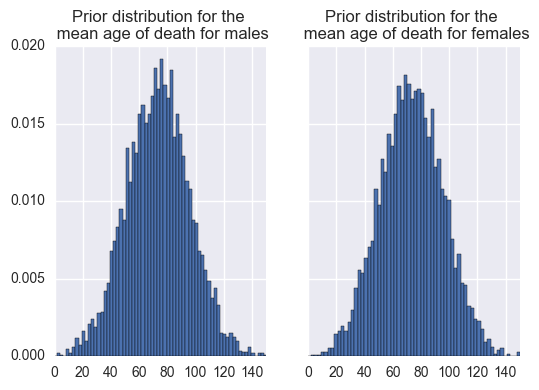

In [13]:
# Now that we have set these priors, we can access them 

samples_male = [male_mean.random()[0] for i in range(5000)]
samples_female = [female_mean.random()[0] for i in range(5000)]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(samples_male, bins=70, normed=True)
ax1.set_title("Prior distribution for the \n mean age of death for males")
ax1.set_xlim([0,150])
ax2.hist(samples_female, bins=70, normed=True)
ax2.set_title("Prior distribution for the \n mean age of death for females")
ax2.set_xlim([0,150])
plt.show()

In [14]:
# Having already instantiated the model and set the mean parameters in the previous cell,
# we now set the standard deviation for each case (also the same) as our prior which is
# uninformative in that it is uniform over the range 0-100

std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    male_std = pm.Uniform('male_std', lower=std_prior_lower, upper=std_prior_upper)
    female_std = pm.Uniform('female_std', lower=std_prior_lower, upper=std_prior_upper)

Applied interval-transform to male_std and added transformed male_std_interval_ to model.
Applied interval-transform to female_std and added transformed female_std_interval_ to model.


In [15]:
# now we set up Bayes rule; the 'observed' are the data points that are passed to the likelihood function
# for the given hypothesis (some mean and standard deviation) which we combine with the priors
# for that hypothesis  to return our posterior probability distribution
# for that given hypothesis, and then interated over all tested hypotheses

with model:
    male = pm.Normal('male', mu=male_mean, sd=male_std, observed=male_deaths)
    female = pm.Normal('female', mu=female_mean, sd=female_std, observed=female_deaths)

In [16]:
with model:
    diff_of_means = pm.Deterministic('difference of means', male_mean - female_mean)
    diff_of_stds = pm.Deterministic('difference of stds', male_std - female_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / np.sqrt((male_std**2 + female_std**2) / 2))

In [17]:
with model:
    trace = pm.sample(25000)

burned_trace=trace[10000:]

Assigned NUTS to male_mean
Assigned NUTS to female_mean
Assigned NUTS to male_std_interval_
Assigned NUTS to female_std_interval_
100%|██████████| 25000/25000 [2:15:47<00:00,  2.99it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x133a3db10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x133d1d790>], dtype=object)

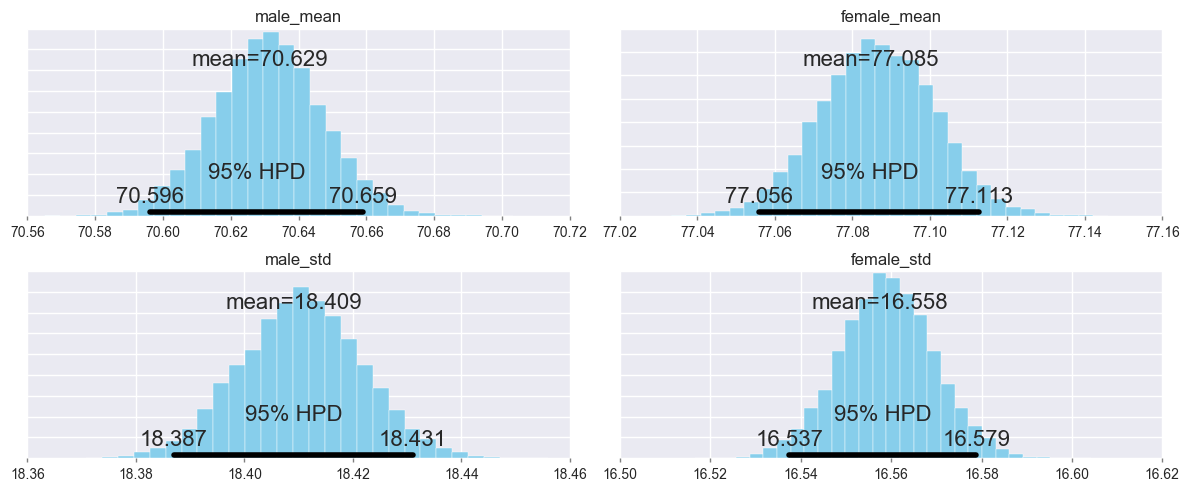

In [18]:
pm.plot_posterior(burned_trace,
                  varnames=['male_mean', 'female_mean', 'male_std', 'female_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12a9962d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122064690>], dtype=object)

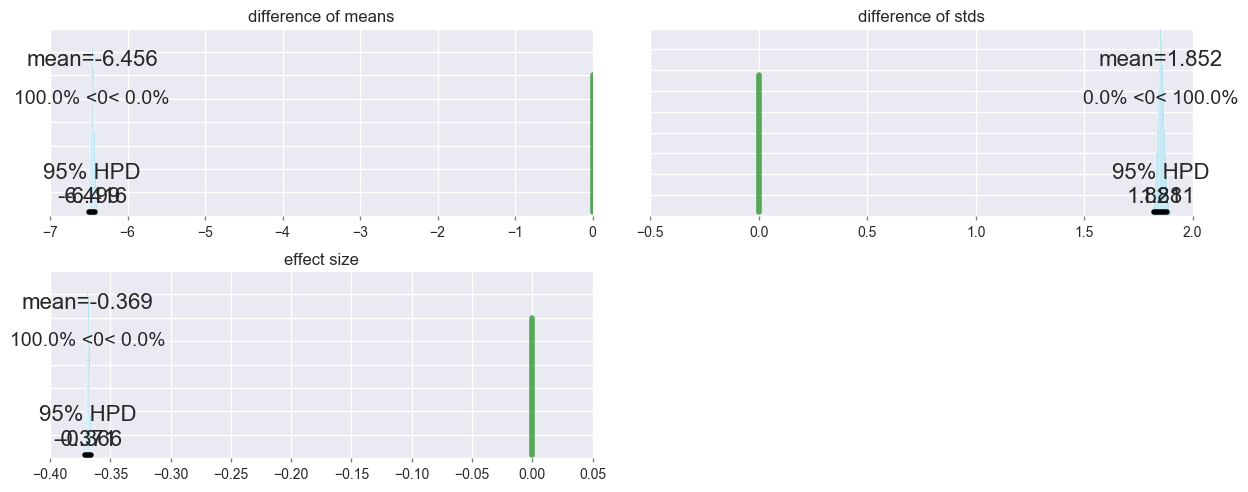

In [19]:
pm.plot_posterior(burned_trace,
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')